In [2]:
!pip install h5py

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from Bio import PDB

# Load Ground truth

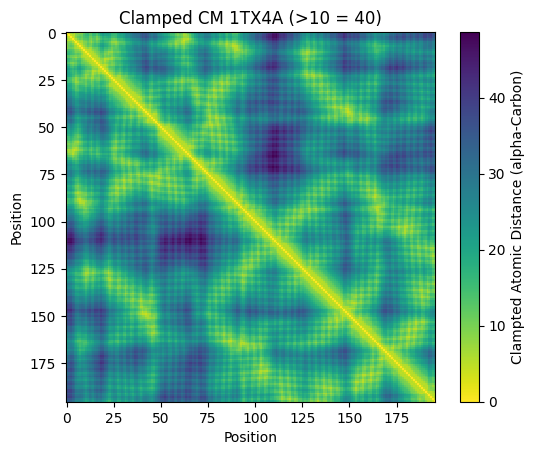

In [4]:

def calculate_contact_map_binary(pdb_file, cutoff=8.0):
    # Initialize parser
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    
    # Get alpha carbon atoms
    ca_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if "CA" in residue:
                    ca_atoms.append(residue["CA"])

    # Get sequence length
    sequence_length = len(ca_atoms)
    
    # Initialize contact map
    contact_map = np.zeros((sequence_length, sequence_length), dtype=int)
    
    # Calculate distances and populate contact map
    for i in range(sequence_length):
        for j in range(i + 1, sequence_length):
            distance = ca_atoms[i] - ca_atoms[j]
            if distance <= cutoff:
                contact_map[i, j] = 1
                contact_map[j, i] = 1  # Symmetric matrix

    return contact_map

def calculate_distance_map(pdb_file):
    # Initialize parser
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    
    # Get alpha carbon atoms
    ca_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if "CA" in residue:
                    ca_atoms.append(residue["CA"])

    # Get sequence length
    sequence_length = len(ca_atoms)
    
    # Initialize distance map
    distance_map = np.zeros((sequence_length, sequence_length), dtype=float)
    
    # Calculate distances and populate distance map
    for i in range(sequence_length):
        for j in range(i + 1, sequence_length):
            distance = ca_atoms[i] - ca_atoms[j]
            distance_map[i, j] = distance
            distance_map[j, i] = distance  # Symmetric matrix

    return distance_map

# Path to your uploaded PDB file
pdb_file_path = 'pdb_files/1TX4_A.pdb'
contact_map_ground_truth = calculate_distance_map(pdb_file_path)

# Map values above 20 to 40
# threshold_value = 10
# new_value = 40
# mapped_matrix = np.where(contact_map_ground_truth > threshold_value, new_value, contact_map_ground_truth)
# plt.figure(figsize=(8, 8))
plt.imshow(contact_map_ground_truth, cmap="viridis_r", interpolation="nearest")
plt.colorbar(label="Clampted Atomic Distance (alpha-Carbon)")
plt.title("Clamped CM 1TX4A (>10 = 40)")
plt.xlabel("Position")
plt.ylabel("Position")
plt.show()


# Load Predicted Matrix

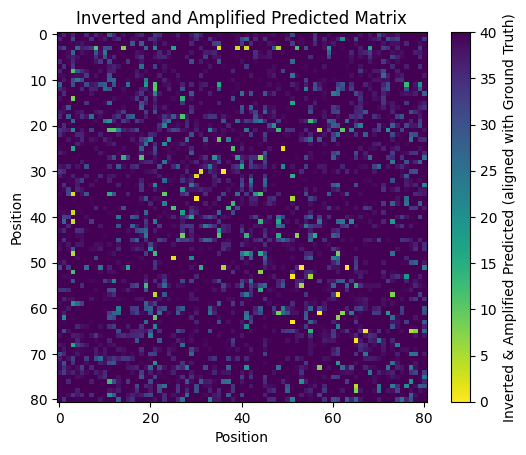

In [5]:
# Open the HDF5 file in read mode
file_path = 'out/1TX4-A_esm2_t33_650M_UR50D.h5'  # replace with your file path
with h5py.File(file_path, 'r') as h5_file:    
    # Access a specific dataset
    dataset = h5_file['1TX4-A']  # replace with your dataset name
    contact_map = dataset[:]

# Amplify the predicted matrix (you can adjust the factor as needed)
amplification_factor = 30 # Value more or less arbitrary right now
amplified_predicted_matrix = contact_map * amplification_factor

# Invert the amplified matrix valu40es to match the ground truth range
max_ground_truth = 40 # Value more or less arbitrary right now
inverted_amplified_matrix = max_ground_truth - amplified_predicted_matrix

# Clip values to avoid negative numbers if necessary
inverted_amplified_matrix = np.clip(inverted_amplified_matrix, 0, max_ground_truth)

# Plot the result
plt.imshow(inverted_amplified_matrix, cmap="viridis_r")
plt.colorbar(label="Inverted & Amplified Predicted (aligned with Ground Truth)")
plt.xlabel("Position")
plt.ylabel("Position")
plt.title("Inverted and Amplified Predicted Matrix")
# plt.savefig(f"amplified_test/map_{af}_{max_gt}")
# plt.clf()
plt.show()

# Calculate IDDT

In [8]:
import numpy as np

def calculate_iddt(matrix_A, matrix_B, threshold=8.0, tolerance=2.0):
    print(matrix_A.shape)
    print(matrix_B.shape)
    # Step 1: Convert to binary contact matrices based on threshold
    contact_A = (matrix_A < threshold).astype(int)
    contact_B = (matrix_B < threshold).astype(int)
    
    # Step 2: Calculate absolute differences
    absolute_differences = np.abs(matrix_A - matrix_B)

    # Step 3: Calculate IDDT scores for each contact
    iddt_scores = np.where(absolute_differences <= tolerance, 1, 0)
    
    # Step 4: Calculate the average IDDT score
    iddt_score = np.sum(iddt_scores) / (matrix_A.shape[0] * matrix_A.shape[1])
    
    return iddt_score

iddt = calculate_iddt(inverted_amplified_matrix, contact_map_ground_truth)
print("IDDT Score:", iddt)


(81, 81)
(196, 196)


ValueError: operands could not be broadcast together with shapes (81,81) (196,196) 